In [1]:
!pip install datasets pandas scikit-learn torch transformers tqdm fugashi unidic-lite accelerate japanize-matplotlib seaborn

  Using cached transformers-4.49.0-py3-none-any.whl.metadata (44 kB)
  Using cached unidic-lite-1.0.8.tar.gz (47.4 MB)
  Preparing metadata (setup.py) ... done
  Using cached tokenizers-0.21.0-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.7 kB)
  Using cached safetensors-0.5.3-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.8 kB)
  Using cached dill-0.3.8-py3-none-any.whl.metadata (10 kB)
Using cached transformers-4.49.0-py3-none-any.whl (10.0 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 671.7/671.7 kB 20.5 MB/s eta 0:00:00
Using cached dill-0.3.8-py3-none-any.whl (116 kB)
Using cached safetensors-0.5.3-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (471 kB)
Using cached tokenizers-0.21.0-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.0 MB)
anceled
ERROR: Operation cancelled by user


### Fine-tuning flow

1. Prepare local dataset or load public dataset
2. Load model and tokenizer
3. Train a model

# Library

In [40]:
from typing import Dict
import os
import tarfile
import warnings

import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix

from datasets import load_dataset
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from transformers import (
    AutoTokenizer, AutoModel, EvalPrediction, TrainingArguments,
    Trainer, EarlyStoppingCallback
)
from transformers.modeling_outputs import ModelOutput

warnings.filterwarnings("ignore")

data_path = "/home/jupyter/llm/finetuning/data"

# Data Preparation

## Load public dataset

In [1]:
raw_datasets = load_dataset("glue", "mrpc")

def tokenize_function(example):
    return tokenizer(example["sentence1"], example["sentence2"], truncation=True)

tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)

/opt/conda/envs/llm_ft/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating test split: 100%|██████████| 1725/1725 [00:00<00:00, 272984.24 examples/s]


## Livedoor news content

### data download

- Src: https://zenn.dev/robes/articles/c2c65d9aef7562
- Dataset: https://www.rondhuit.com/download/ldcc-20140209.tar.gz

In [9]:
!mkdor {data_path}ldcc_data

# ファイルパスを指定する
tar_file_path = f"{data_path}/uploaded/ldcc-20140209.tar.gz"
extract_folder = f"{data_path}/ldcc_data/"

!tar -xf {tar_file_path} -C {extract_folder}
!ls {extract_folder}text

CHANGES.txt	it-life-hack	movie-enter  sports-watch
README.txt	kaden-channel	peachy	     topic-news
dokujo-tsushin	livedoor-homme	smax


### data formatter

In [10]:
def read_articles_from_directory(directory_path):
    #ディレクトリーの中から記事のテキストファイルのパスをリストとして読み込む
    files = [f for f in os.listdir(directory_path) if f not in ["LICENSE.txt"]]
    
    articles = []
    for file in files:
        #記事を一つずつ読み込み、url,date,bodyに分け、辞書を作る
        with open(os.path.join(directory_path, file), 
		"r", encoding="utf-8") as f:
            lines = f.readlines()
            articles.append({
                "url": lines[0].strip(),
                "date": lines[1].strip(),
                "body": ''.join(lines[2:]).strip()
            })
    
    return articles

In [12]:
# 各記事のディレクトリーを取得する
directories = [d for d in os.listdir(extract_folder + "text/") 
	if d not in ["CHANGES.txt", "README.txt"]]

# カテゴリーごとのCSVファイルを作る
csv_file_paths = {}
for directory in directories:
    # Read articles from the category directory
    articles = read_articles_from_directory(extract_folder + "text/" + directory)
    df = pd.DataFrame(articles)

    # Save to CSV
    csv_path = f"{data_path}/ldcc_data/content/{directory}.csv"
    df.to_csv(csv_path, index=False)
    csv_file_paths[directory] = csv_path

print(csv_file_paths)

{'kaden-channel': '../data/ldcc_data/content/kaden-channel.csv', 'livedoor-homme': '../data/ldcc_data/content/livedoor-homme.csv', 'topic-news': '../data/ldcc_data/content/topic-news.csv', 'peachy': '../data/ldcc_data/content/peachy.csv', 'smax': '../data/ldcc_data/content/smax.csv', 'dokujo-tsushin': '../data/ldcc_data/content/dokujo-tsushin.csv', 'it-life-hack': '../data/ldcc_data/content/it-life-hack.csv', 'sports-watch': '../data/ldcc_data/content/sports-watch.csv', 'movie-enter': '../data/ldcc_data/content/movie-enter.csv'}


In [48]:
new_data = []

for directory in directories:
    data_csv = pd.read_csv(f"{data_path}/ldcc_data/content/{directory}.csv")
    for id, row in data_csv.iterrows():
        title = row["body"].split("\n")[0]
        body = "\n".join(row["body"].split("\n")[1:])
        new_data.append([
            directory, title, body
        ])
        
new_data = pd.DataFrame(new_data, columns = ["category", "title", "body"])

new_data.to_pickle(f"{data_path}ldcc_data/livedoor_data.pkl")

# Data Loading

## Livedoor news content

In [2]:
df = pd.read_pickle(f"{data_path}/ldcc_data/livedoor_data.pkl")
# カテゴリーのID列を付与しておく
categories = df['category'].unique().tolist()
category2id = {cat: categories.index(cat) for cat in categories}
df['category_id'] = df['category'].map(lambda x: category2id[x])

df.sample(3)

,category,title,body,category_id
5273,it-life-hack,ご当地アプリがiPhoneカバーに！ 登場！ぐんまのやぼう ＆ にほんのあらそい iPhon...,株式会社ラナは、アプリ作家のRucKyGAMESとライセンス契約を結び、人気のご当地アプリ「...,6
3388,smax,テンキー×タッチでスマートフォンを思いのままに。「AQUOS PHONE SL IS15SH...,スライドテンキーなAQUOS PHONEがフルモデルチェンジ！ \n\n既報のとおり、KDD...,4
6418,sports-watch,【Sports Watch】ノムさんボヤく「佑ちゃん、ちょっと騒ぎ過ぎ」,15日深夜、TBSのスポーツ番組「S1」では、毎週恒例となった野村克也氏による「ノムさんのボ...,7


# Data Preprocessing

In [3]:
train_df, eval_df = train_test_split(df, train_size=0.7)
eval_df, test_df = train_test_split(eval_df, train_size=0.5)
print('train size', train_df.shape)
print('eval size', eval_df.shape)
print('test size', test_df.shape)
# train size (5156, 4)
# eval size (1105, 4)
# test size (1106, 4)

train size (5156, 4)
eval size (1105, 4)
test size (1106, 4)


# Dataset class

In [4]:
class LivedoorDataset(Dataset):
    def __init__(self, df):
        self.features = [
            {
                'title': row.title,
                'category_id': row.category_id
            } for row in tqdm(df.itertuples(), total=df.shape[0])
        ]
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx]

train_dataset = LivedoorDataset(train_df)
eval_dataset = LivedoorDataset(eval_df)
test_dataset = LivedoorDataset(test_df)

100%|██████████| 1106/1106 [00:00<00:00, 490525.56it/s]


In [5]:
train_dataset[0]

{'title': 'AKB指原莉乃の衝撃交際報道、小林よしのり氏の見解は？', 'category_id': 2}

# Data collator

## Livedoor news content

In [50]:
# pretrained_model = 'deepseek-ai/DeepSeek-R1'

pretrained_model = 'cl-tohoku/bert-base-japanese-whole-word-masking'
# pretrained_model = 'facebook/opt-125m'
# pretrained_model = 'microsoft/phi-2'
# pretrained_model = 'meta-llama/Llama-3.1-8B-Instruct'
# pretrained_model = 'lmsys/vicuna-7b-v1.5'
# pretrained_model = 'mistralai/Mistral-7B-v0.1'
# pretrained_model = 'google/gemma-2-2b-it'
# pretrained_model = 'Qwen/Qwen2.5-VL-7B-Instruct'

output_path = "/home/jupyter/llm/finetuning/output"
target_model = pretrained_model.replace("/", "_")

os.makedirs(f"{output_path}/{target_model}", exist_ok=True)

print(target_model)

cl-tohoku_bert-base-japanese-whole-word-masking


In [43]:
class DataCollator():
    def __init__(self, tokenizer, max_length=512):
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __call__(self, examples):
        examples = {
            'title': list(map(lambda x: x['title'], examples)),
            'category_id': list(map(lambda x: x['category_id'], examples))
        }
        
        encodings = self.tokenizer(examples['title'],
                                   padding=True,
                                   truncation=True,
                                   max_length=self.max_length,
                                   return_tensors='pt')
        encodings['category_id'] = torch.tensor(examples['category_id'])
        return encodings

In [44]:
tokenizer = AutoTokenizer.from_pretrained(pretrained_model)
data_collator = DataCollator(tokenizer)

In [45]:
loader = DataLoader(train_dataset, collate_fn=data_collator, batch_size=8, shuffle=True)
batch = next(iter(loader))
for k,v in batch.items():
    print(k, v.shape)
# input_ids torch.Size([8, 42])
# token_type_ids torch.Size([8, 42])
# attention_mask torch.Size([8, 42])
# category_id torch.Size([8])

print(batch)
# {'input_ids': tensor([[    2,  8485, 10731,     6, 14484, 28687, 17658, 14239, 17298,  5191,
#            231,     7,   147, 29012,  4955,    11,  2143,   679,   908,    19,
#            159,    37, 11780,   580,  1484,     3,     0,     0,     0,     0,・・・
# 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,・・・
# 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ・・・
# 'category_id': tensor([4, 4, 6, 1, 3, 7, 3, 6])}

input_ids torch.Size([8, 30])
token_type_ids torch.Size([8, 30])
attention_mask torch.Size([8, 30])
category_id torch.Size([8])
{'input_ids': tensor([[    2,   355, 29197,    14, 23702,   240, 29256,     5, 24666,     7,
          6068, 22675,  3919, 29217,     3,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0],
        [    2, 21203, 28589,  9929,     6,  6961,  2984, 28865,  1949, 28642,
         29182, 10688,  1389, 14400,    57,   143,   518,  6724,  5464,    36,
         18532, 12305, 29141, 29182,  2668,   582,    38,    11,   602,     3],
        [    2,  9680, 21436, 28589,   472, 19366,  9594,  9002,     5,  1075,
            81, 28422,     6,   608,    51,     5,   408,     5,  1052, 29167,
             9,  2935,     3,     0,     0,     0,     0,     0,     0,     0],
        [    2,  5696,    35, 14201,     5,  6905,     7,  2956, 28859,    18,
          5416,    14, 21080,     3,     0,     0,     0,     0, 

# Modeling

In [46]:
class Bert_Net(nn.Module):
    def __init__(self, pretrained_model, num_categories, loss_function=None):
        super().__init__()
        self.bert = pretrained_model
        self.hidden_size = self.bert.config.hidden_size
        self.linear = nn.Linear(self.hidden_size, num_categories)
        self.loss_function = loss_function
    
    def forward(self,
                input_ids,
                attention_mask=None,
                position_ids=None,
                token_type_ids=None,
                output_attentions=False,
                output_hidden_states=False,
                category_id=None):
        
        outputs = self.bert(input_ids,
                            attention_mask=attention_mask,
                            position_ids=position_ids,
                            token_type_ids=token_type_ids,
                            output_attentions=output_attentions,
                            output_hidden_states=output_hidden_states)
        
        state = outputs.last_hidden_state[:, 0, :]
        state = self.linear(state)
        
        loss=None
        if category_id is not None and self.loss_function is not None:
            loss = self.loss_function(state, category_id)
        
        attentions=None
        if output_attentions:
            attentions=outputs.attentions
        
        hidden_states=None
        if output_hidden_states:
            hidden_states=outputs.hidden_states
        
        return ModelOutput(
            logits=state,
            loss=loss,
            last_hidden_state=outputs.last_hidden_state,
            attentions=attentions,
            hidden_states=hidden_states
        )
    
class OPT_Net(nn.Module):
    def __init__(self, pretrained_model, num_categories, loss_function=None):
        super().__init__()
        self.bert = pretrained_model
        self.hidden_size = self.bert.config.hidden_size
        self.linear = nn.Linear(self.hidden_size, num_categories)
        self.loss_function = loss_function

    def forward(self,
                input_ids,
                attention_mask=None,
                position_ids=None,
                token_type_ids=None,
                output_attentions=False,
                output_hidden_states=False,
                category_id=None):
        
        # Check if the model supports `token_type_ids`
        if "token_type_ids" in self.bert.forward.__code__.co_varnames:
            outputs = self.bert(input_ids=input_ids,
                                attention_mask=attention_mask,
                                position_ids=position_ids,
                                token_type_ids=token_type_ids,
                                output_attentions=output_attentions,
                                output_hidden_states=output_hidden_states)
        else:
            outputs = self.bert(input_ids=input_ids,
                                attention_mask=attention_mask,
                                position_ids=position_ids,
                                output_attentions=output_attentions,
                                output_hidden_states=output_hidden_states)
        
        # Extract the CLS token representation
        state = outputs.last_hidden_state[:, 0, :]
        logits = self.linear(state)
        
        # Compute loss if `category_id` and `loss_function` are provided
        loss = None
        if category_id is not None and self.loss_function is not None:
            loss = self.loss_function(logits, category_id)
        
        # Extract attentions and hidden states if requested
        attentions = outputs.attentions if output_attentions else None
        hidden_states = outputs.hidden_states if output_hidden_states else None
        
        # Return a ModelOutput object
        return ModelOutput(
            logits=logits,
            loss=loss,
            last_hidden_state=outputs.last_hidden_state,
            attentions=attentions,
            hidden_states=hidden_states
        )

In [47]:
loss_fct = nn.CrossEntropyLoss()
pretrained_model = AutoModel.from_pretrained(pretrained_model)
if target_model in [
    "facebook_opt-125m", 
]:
    net = OPT_Net(pretrained_model, len(categories), loss_fct)
elif target_model in [
    "cl-tohoku_bert-base-japanese-whole-word-masking"
]:
    net = Bert_Net(pretrained_model, len(categories), loss_fct)

# Custom

## compute_metrics

In [48]:
def custom_compute_metrics(res: EvalPrediction) -> Dict:
    # res.predictions, res.label_idsはnumpyのarray
    pred = res.predictions.argmax(axis=1)
    target = res.label_ids
    precision = precision_score(target, pred, average='macro')
    recall = recall_score(target, pred, average='macro')
    f1 = f1_score(target, pred, average='macro')
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

## TrainingArguments

In [51]:
training_args = TrainingArguments(
    output_dir=f'{output_path}/{target_model}',
    save_safetensors=False,
    eval_strategy='epoch',
    logging_strategy='epoch',
    save_strategy='epoch',
    save_total_limit=1,
    label_names=['category_id'],
    lr_scheduler_type='constant',
    metric_for_best_model='f1',
    load_best_model_at_end=True,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=20,
    remove_unused_columns=False,
    report_to='none'
)

# Training

In [52]:
trainer = Trainer(
    model=net,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=custom_compute_metrics,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

trainer.train(ignore_keys_for_eval=['last_hidden_state', 'hidden_states', 'attentions'])

Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,0.883400,0.414238,0.846708,0.845979,0.844629
2,0.268500,0.380594,0.877314,0.868031,0.868470
3,0.114400,0.381189,0.884883,0.879700,0.880874
4,0.047600,0.492750,0.879421,0.866745,0.870984
5,0.031400,0.630214,0.876514,0.866693,0.868621
6,0.024000,0.561249,0.887535,0.876166,0.878803


TrainOutput(global_step=486, training_loss=0.2282260376730083, metrics={'train_runtime': 271.4106, 'train_samples_per_second': 379.941, 'train_steps_per_second': 5.969, 'total_flos': 0.0, 'train_loss': 0.2282260376730083, 'epoch': 6.0})

## restart from checkpoint

In [ ]:
# trainer.train(ignore_keys_for_eval=['last_hidden_state', 'hidden_states', 'attentions'],
#               resume_from_checkpoint=True)

# Save model

In [53]:
trainer.save_state()
trainer.save_model()

# Predict test data

                precision    recall  f1-score   support

 kaden-channel       0.99      0.91      0.95       129
livedoor-homme       0.85      0.67      0.75        69
    topic-news       0.87      0.87      0.87       115
        peachy       0.72      0.88      0.79       118
          smax       0.97      0.96      0.97       138
dokujo-tsushin       0.88      0.82      0.85       126
  it-life-hack       0.85      0.96      0.90       135
  sports-watch       0.95      0.89      0.92       133
   movie-enter       0.83      0.83      0.83       143

      accuracy                           0.88      1106
     macro avg       0.88      0.87      0.87      1106
  weighted avg       0.88      0.88      0.88      1106

Classification report saved to /home/jupyter/llm/finetuning/output
Confusion matrix saved to /home/jupyter/llm/finetuning/output/cl-tohoku_bert-base-japanese-whole-word-masking/confusion_matrix.png


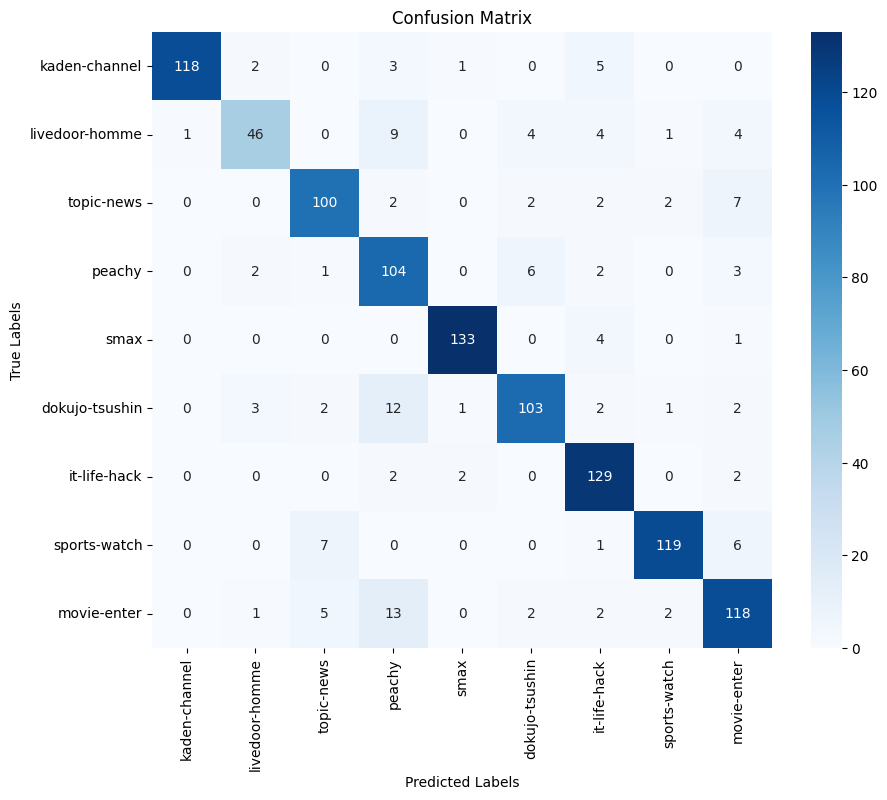

In [54]:
pred_result = trainer.predict(test_dataset, ignore_keys=['loss', 'last_hidden_state', 'hidden_states', 'attentions'])
test_df['predict'] = pred_result.predictions.argmax(axis=1).tolist()

report = classification_report(test_df['category_id'], test_df['predict'], target_names=categories)
print(report)

with open(f'{output_path}/{target_model}/classification_report.txt', "w") as f:
    f.write(report)

print(f"Classification report saved to {output_path}")

# 混同行列を生成
conf_matrix = confusion_matrix(test_df['category_id'], test_df['predict'])

# 混同行列を可視化
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=categories, yticklabels=categories)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# 混同行列を画像として保存
conf_matrix_path = f'{output_path}/{target_model}/confusion_matrix.png'
plt.savefig(conf_matrix_path)
print(f"Confusion matrix saved to {conf_matrix_path}")

# 表示
plt.show()